In [1]:
import networkit as nit
import numpy as np
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import copy
import random

In [2]:
def louvain(graph, passes = 1):
    '''
    implements louvain method of clustering
    still need to implement passes (for now change number of iterations in change_modularity to increase modularity)
    and total_modularity where algo stops when modularity of whole graph doesn't change
    '''
    graph_lst = [graph]
    for j in range(0,passes):
        mapping = modularity_optimization(graph_lst[-1]) #first phase - modularity optimization
        new_graph = copy.deepcopy(graph_lst[-1]) #makes a copy to make changes to graph
        new_graph, nodes_lst = community_aggression(mapping,new_graph) #second phase - community aggression
        visualize(graph, [i for i in graph.iterNodes()],[i for i in nodes_lst.values()])
        graph_lst.append(new_graph) #appends new graph to run second pass
    return 

In [3]:
def community_aggression(mapping, graph):
    '''
    groups all the nodes with corresponding communities by making a new node for each community
    '''
    community = set(frozenset(i) for i in mapping.values()) 
    new = dict() # a mapping to maintain which node belongs to which new node
    for i in community:
        newNode = graph.addNode() #makes a new node
        new[newNode]= i #adds it to the mapping
        for node in i:
            for neighbor in graph.iterNeighbors(node): #loops through each neighbor of node to link edges to new community node
                if neighbor in i:
                    graph.addEdge(newNode,newNode,graph.weight(node,neighbor)) #if node has an edge to a node which is in same community then it makes a self-loop
                else:
                    graph.addEdge(newNode,neighbor,graph.weight(node,neighbor))
            graph.removeNode(node)
    return graph, new #returns new graph and mapping in the form of a tuple

In [16]:
def modularity_optimization(graph):
    '''
    assigns each node to a community which maximizes the modularity
    '''
    nodes = [i for i in graph.iterNodes()] #list of nodes
    mapping = {i:{i} for i in graph.iterNodes()} #creates a mapping between nodes and its community
                                                 # initially each node is assigned to its own community
    for _ in range(0,10): # still need to implement passes in louvain so to see better modularity u can increase number of iterations
        for nodeid in nodes:
            lst = [i for i in graph.iterNeighbors(nodeid)] #gets all the neighbors of nodeid
            nodeid_community = copy.deepcopy(mapping[nodeid]) #makes a copy of the assigned community
            if lst:
                mergeid = max(lst, key=lambda x: change_modularity(nodeid,mapping[x],graph)) #gets the node which gives max modularity increase
                                                                                             #if multiple nodes gives same modularity increase then node which is already in nodeid community is given preference
                if mergeid in nodeid_community: #if mergeid is already in community then no need to do anything
                    continue
                k = copy.deepcopy(mapping[mergeid]) #makes a copy of mergeid's community
                for i in k: #appends nodeid to the community
                    mapping[i].add(nodeid)
                for i in nodeid_community: #removes nodeid from initially assigned community
                    mapping[i].remove(nodeid)
                mapping[nodeid] = k.union({nodeid}) #adds new community of nodeid to the mapping
    return mapping

In [17]:
def change_modularity(node, community, graph):
    ''' implements change in modularity equation and returns a tuple where first arg is change in modularity and second is either 1 or 0 depending if node is in the community
    '''
    kiin = sum(graph.weight(node, i) for i in community)
    ki = graph.weightedDegree(node)
    sum_tot = sum(graph.weightedDegree(i) for i in community)
    m = graph.totalEdgeWeight()/2
    return (kiin/m)-((sum_tot*ki)/(2*m*m)), int(node in community)

In [25]:
def visualize(graph, nodelst = [], lst = []):
    ''' visiualizes the graph
    '''
    plt.clf() #clear the sreen
    matrix = nit.algebraic.adjacencyMatrix(graph, matrixType='sparse') #make adjancency matrix of graph to convert it to a graph object of networkx
    G2 = nx.from_scipy_sparse_matrix(matrix)# converts the graph
    if not lst: #this is for just viewing graph
        nx.draw_circular(G2,with_labels=True,nodelist=lst)
        nx.draw_circular(G2,with_labels=True)
    else: #this is for viewing graph with colors to see clusters
        colors = [random.uniform(0,0.1) for _ in range(0,len(lst))]
        color_lst = []
        for i in nodelst:
            for index, j in enumerate(lst):
                if i in j:
                    color_lst.append(colors[index])
        nx.draw_circular(G2,nodelist = nodelst ,with_labels=True, node_color = color_lst)
    plt.axis('equal')

In [32]:
graph = nit.generators.ClusteredRandomGraphGenerator(10,3,0.7,0.1).generate()
#graph = nit.generators.ErdosRenyiGenerator(10, 0.1, directed = False, selfLoops = False).generate()

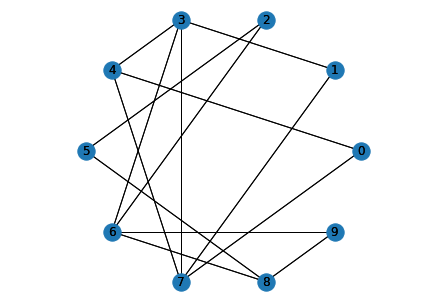

In [33]:
visualize(graph)

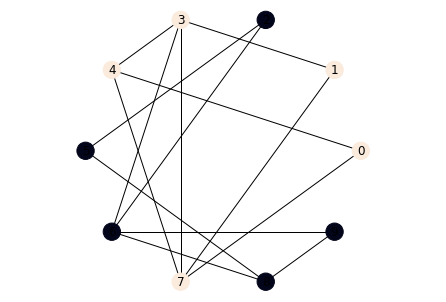

In [34]:
louvain(graph)